In [1]:
import open3d
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import copy

import matplotlib.pyplot as plt
import utils.registration as registration
import utils.functions as functions
import utils.transform as transform
import utils.pointcloud as pointcloud
import utils.fread as fread
import utils.FCGF as FCGF

from utils.config import Config
from utils.depth_camera import DepthCamera, DepthCameraParams
from scipy.ndimage import gaussian_filter1d
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
pcd = open3d.io.read_point_cloud("../calibration/dev_0.pcd")

open3d.visualization.draw_geometries([pcd])

pts = np.asarray(pcd.points)

In [3]:
camera_params = DepthCameraParams(f"metadata/device-0.json")
depth_camera = DepthCamera(camera_params)

In [17]:
def get_projection_matrix(camera_params):
    return np.array([
        [camera_params.fx, 0, camera_params.px],
        [0, camera_params.fy, camera_params.py],
        [0, 0, 1]
    ])


In [6]:
a = np.ones((5, 3))

array([[[1., 1., 1.]],

       [[1., 1., 1.]],

       [[1., 1., 1.]],

       [[1., 1., 1.]],

       [[1., 1., 1.]]])

In [18]:
projection_matrix = get_projection_matrix(camera_params)

In [56]:
fx = 440
fy = 440
px = 318
py = 238

projection_matrix = np.array([
    [fx, 0, px],
    [0, fy, py],
    [0, 0, 1]
])

In [57]:
depth_image = pts @ projection_matrix.T

In [58]:
z = depth_image[:, 2]
u = np.array(depth_image[:, 0] / z, dtype=int)
v = np.array(depth_image[:, 1] / z, dtype=int)

In [59]:
depth_image = np.zeros((480, 640))

depth_image[v, u] = z * 4000

depth_image = np.array(depth_image, dtype=np.uint16)


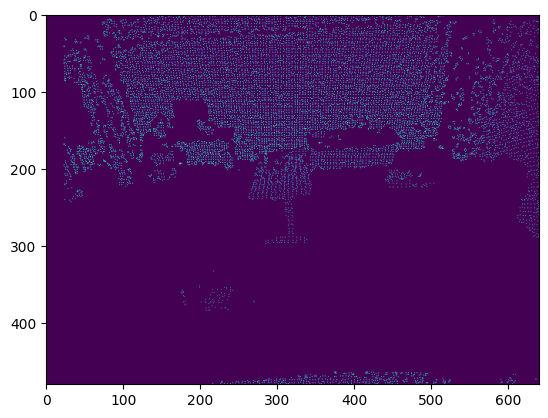

In [60]:
plt.imshow(depth_image)

In [47]:
reconstructed = depth_camera.depth_image_to_point_cloud(depth_image)

In [49]:
reconstructed = pointcloud.make_pcd(reconstructed)

In [50]:
pointcloud.view(reconstructed)

In [ ]:
np.save("../calibration/env_static.npy", pts)

In [3]:
def voxel_downsample(point_cloud, voxel_size):
    # Determine the minimum and maximum coordinates of the point cloud
    min_coord = np.min(point_cloud, axis=0)
    max_coord = np.max(point_cloud, axis=0)
    
    # Calculate the dimensions of the voxel grid
    grid_dims = np.ceil((max_coord - min_coord) / voxel_size).astype(int)
    
    # Create an empty voxel grid
    voxel_grid = [[] for _ in range(np.prod(grid_dims))]
    
    # Compute the voxel indices for each point in the point cloud
    voxel_indices = np.floor((point_cloud - min_coord) / voxel_size).astype(int)
    
    # Assign points to corresponding voxels
    for i, voxel_index in enumerate(voxel_indices):
        voxel_grid[np.ravel_multi_index(voxel_index, grid_dims)].append(point_cloud[i])
    
    # Select representative points from each voxel
    downsampled_points = []
    for voxel_points in voxel_grid:
        if voxel_points:
            representative_point = np.mean(voxel_points, axis=0)
            downsampled_points.append(representative_point)
    
    return np.array(downsampled_points)

In [ ]:
vertices = np.loadtxt("temp/global.txt")

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(vertices)

# pcd = open3d.geometry.voxel_down_sample(pcd, voxel_size=0.1)

In [42]:
%timeit open3d.geometry.voxel_down_sample(pcd, voxel_size=0.1)

6.56 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
def remove_outliers(pcd):
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    return pcd.select_by_index(ind)

In [6]:
global_pcd = open3d.geometry.PointCloud()

for device in range(3):
    img_files = glob.glob(f"calib/dev_{device}_*.png")
    img_file = img_files[0]
    
    depth_img = Image.open(img_file).convert("I")
    
    camera_params = DepthCameraParams(f"metadata/device-{device}.json")
    depth_camera = DepthCamera(camera_params)
    
    pcd = depth_camera.depth_image_to_point_cloud(np.asarray(depth_img))
    pcd = pointcloud.make_pcd(pcd)
    pcd = pcd.voxel_down_sample(0.05)
    pcd = remove_outliers(pcd)
    
    pose = np.loadtxt(f"metadata/device-{device}.txt")
    pcd.transform(pose)
    
    global_pcd += pcd
    
    # open3d.visualization.draw_geometries([pcd])
    # open3d.io.write_point_cloud(f"../calibration/dev_{device}.pcd", pcd)
    
open3d.visualization.draw_geometries([global_pcd])

In [51]:
open3d.visualization.draw_geometries([pcd])

In [23]:
vertices_downsampled = voxel_downsample(vertices, voxel_size=0.1)

pcd_downsampled = open3d.geometry.PointCloud()
pcd_downsampled.points = open3d.utility.Vector3dVector(vertices_downsampled)

In [12]:
open3d.visualization.draw_geometries([pcd_downsampled])

In [24]:
%timeit voxel_downsample(vertices, voxel_size=0.1)

755 ms ± 8.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
global_pcds = [np.zeros((1, 3)) for _ in range(3)]

In [47]:
for i in range(3):
    vertices = np.loadtxt(f"temp/dev_{i}.txt")
    # vertices = np.concatenate((vertices, np.ones((vertices.shape[0], 1))), axis=1)
    # transformation = np.loadtxt(f"metadata/device-{i}.txt")
    # vertices = np.dot(transformation, vertices.T).T
    global_pcds[i] = vertices

In [48]:
global_pcd = open3d.geometry.PointCloud()
global_pcd.points = open3d.utility.Vector3dVector(np.vstack(global_pcds))

In [49]:
open3d.visualization.draw_geometries([global_pcd])

In [15]:
vertices = np.loadtxt("temp/global.txt")

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(vertices[:, :3])

open3d.visualization.draw_geometries([pcd])

# open3d.io.write_point_cloud("temp/larc_kitche_v6_pcd.pcd", pcd)

In [14]:
for device in range(3):
    matrix_1 = np.loadtxt(f"temp/global_pcd/device-{device}-base.txt")
    matrix_2 = np.loadtxt(f"temp/global_pcd/device-{device}-aligned.txt")

    matrix = np.dot(matrix_2, matrix_1)

    np.savetxt(f"temp/global_pcd/device-{device}.txt", matrix, fmt="%.12f")